In [16]:
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import nibabel as nib
import matplotlib.pyplot as plt

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as TF
import torch.nn.init as init
from torchsummary import summary

# Image preprocessing
from skimage.transform import resize

# Model and training utilities
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split

# Setup
import logging

import pickle 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dir = Path("/work3/kvabo/PKGCTORG/newCT")

# Loss

In [17]:
maeLoss = nn.L1Loss()

# QC U-Net


In [18]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU()
        )

    def forward(self, x):
        return self.block(x)

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x_conv = self.conv(x)
        x_pool = self.pool(x_conv)
        return x_pool, x_conv

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.block = nn.Sequential(
            nn.BatchNorm2d(out_channels + skip_channels),
            nn.PReLU(),
            nn.Conv2d(out_channels + skip_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU()
        )

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat((skip, x), dim=1)
        return self.block(x)

class QCUNet(nn.Module):
    def __init__(self, in_channels=2):
        super(QCUNet, self).__init__()
        self.enc1 = EncoderBlock(in_channels, 40)
        self.enc2 = EncoderBlock(40, 40)
        self.enc3 = EncoderBlock(40, 80)
        self.enc4 = EncoderBlock(80, 160)
        self.enc5 = EncoderBlock(160, 320)

        self.bottleneck = ConvBlock(320, 640)

        self.dec5 = DecoderBlock(640, 320, 320)
        self.dec4 = DecoderBlock(320, 160, 160)
        self.dec3 = DecoderBlock(160, 80, 80)
        self.dec2 = DecoderBlock(80, 40, 40)
        self.dec1 = DecoderBlock(40, 40, 40)

        self.output_conv = nn.Conv2d(40, 1, kernel_size=1)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Outputs shape (B, 1, 1, 1)

    def forward(self, x):
        x1_pool, x1 = self.enc1(x)
        x2_pool, x2 = self.enc2(x1_pool)
        x3_pool, x3 = self.enc3(x2_pool)
        x4_pool, x4 = self.enc4(x3_pool)
        x5_pool, x5 = self.enc5(x4_pool)

        x = self.bottleneck(x5_pool)

        x = self.dec5(x, x5)
        x = self.dec4(x, x4)
        x = self.dec3(x, x3)
        x = self.dec2(x, x2)
        x = self.dec1(x, x1)

        x = self.output_conv(x)                    # (B, 1, H, W)
        x = self.global_avg_pool(x)                # (B, 1, 1, 1)
        return x.view(x.size(0), -1)               # Flatten to shape (B, 1)


In [19]:
model = model.to(device)
summary(model, (2, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 40, 256, 256]             760
       BatchNorm2d-2         [-1, 40, 256, 256]              80
             PReLU-3         [-1, 40, 256, 256]               1
            Conv2d-4         [-1, 40, 256, 256]          14,440
       BatchNorm2d-5         [-1, 40, 256, 256]              80
             PReLU-6         [-1, 40, 256, 256]               1
         ConvBlock-7         [-1, 40, 256, 256]               0
         MaxPool2d-8         [-1, 40, 128, 128]               0
      EncoderBlock-9  [[-1, 40, 128, 128], [-1, 40, 256, 256]]               0
           Conv2d-10         [-1, 40, 128, 128]          14,440
      BatchNorm2d-11         [-1, 40, 128, 128]              80
            PReLU-12         [-1, 40, 128, 128]               1
           Conv2d-13         [-1, 40, 128, 128]          14,440
      BatchNorm2d-14    

# Try overfitting to check that it works

In [20]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms.functional as TF
from pathlib import Path

class QCKidneyDataset(Dataset):
    def __init__(self, qc_dir, ct_dir):
        self.qc_dir = Path(qc_dir)
        self.ct_dir = Path(ct_dir)

        # Load CSV containing metadata (case, slice, dsc)
        self.data = pd.read_csv(self.qc_dir / "results.csv")  # <--- FIXED: 'self.qcData' → 'self.data'

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        case_number = int(row['case'])
        slice_idx = int(row['slice'])
        dsc = float(row['dsc'])

        # Load predicted segmentation
        seg_path = self.qc_dir / f"{case_number}_slice_{slice_idx}_pred.npy"
        seg = np.load(seg_path).astype(np.float32)

        # Load CT slice
        ct_path = self.ct_dir / f"volume-{case_number}.npy"
        ct = np.load(ct_path)[:, :, slice_idx]  # shape: [H, W]
        ct_image = Image.fromarray(ct).convert("F")
        ct_image = TF.resize(ct_image, (256, 256))
        ct_resized = np.array(ct_image, dtype=np.float32)

        # Stack CT and prediction
        X = np.stack([ct_resized, seg], axis=0)  # shape: [2, 256, 256]
        X_tensor = torch.tensor(X)

        return X_tensor, torch.tensor(dsc, dtype=torch.float32), case_number, slice_idx


In [6]:
from torch.utils.data import DataLoader, Subset

# Instantiate the full dataset once (using your QCKidneyDataset with all data)
full_dataset = QCKidneyDataset("predictions/qcKidneyDsc0.5", dir)

# Define indices for test and train splits by slicing the dataset indices
test_indices = list(range(1, 11))    # idx from 1 to 10 inclusive
train_indices = list(range(11, 170))  # idx from 11 to 20 inclusive

# Create subsets for train and test
test_dataset = Subset(full_dataset, test_indices)
train_dataset = Subset(full_dataset, train_indices)

# DataLoader parameters
batch_size = 5

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
model = QCUNet()

def init_he(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(init_he)
model = model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.7)


# Training loop
model.train()
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (X, dsc, case_ids, slice_indices) in enumerate(train_loader):
        X = X.to(device)
        dsc = dsc.to(device)

        opt.zero_grad()
        outputs = model(X)  # Regression: output shape [batch_size, 1]
        pred_dsc = torch.sigmoid(outputs).squeeze()

        loss = maeLoss(pred_dsc, dsc)
        loss.backward()
        opt.step()
        running_loss += loss.item()

    scheduler.step()
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

KeyboardInterrupt: 

In [10]:
diceLoss = smp.losses.DiceLoss(mode='binary', from_logits=False, eps=1e-7, smooth = 1)

In [30]:
a=np.ones((4,2))
#a =np.flatten(a)
np.sum(a)

8.0

tensor([0.0346, 0.1099, 0.1625, 0.1554, 0.5416]) tensor([0, 0, 0, 0, 0]) tensor([35, 36, 37, 38, 39])
0
tensor([0.2127, 0.2974, 0.2954, 0.3469, 0.5093]) tensor([0, 0, 0, 0, 0]) tensor([40, 41, 42, 43, 44])
1


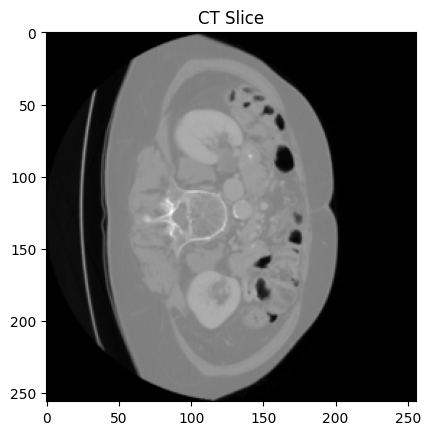

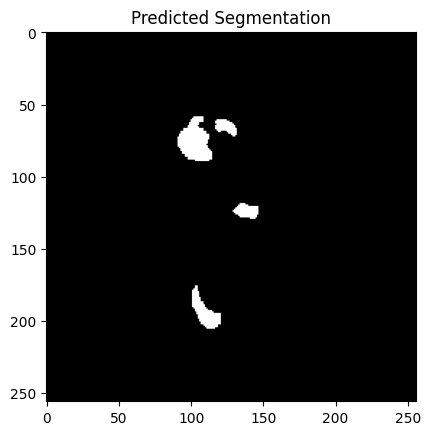

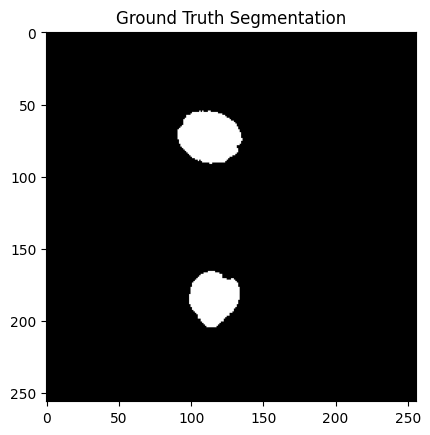

DSC: tensor(0.5093)
(256, 256)
(256, 256)
MVSF: 0.7317972350230415


In [33]:
target_class =4
def mvsf(pred, gt):
    y = np.sum(gt)
    z = np.sum(pred)
    mvsf = 2*(y-z)/(y+z)
    return mvsf

for batch_idx, (X, dsc, case_ids, slice_indices) in enumerate(test_loader):
    print(dsc, case_ids, slice_indices)
    print(batch_idx)

    if epoch == 0 and batch_idx == 1:
        # Display CT slice and predicted segmentation
        plt.imshow(X[4][0].cpu().numpy(), cmap='gray')
        plt.title("CT Slice")
        plt.show()

        pred_seg = X[4][1].cpu().numpy()
        plt.imshow(pred_seg, cmap='gray')
        plt.title("Predicted Segmentation")
        plt.show()

        # Load and process ground truth
        gt_path = dir / f"labels-{case_ids[4]}.npy"
        gt_full = np.load(gt_path)  # shape [H, W, D]
        gt = (gt_full[:, :, slice_indices[4]] == target_class).astype(np.uint8)

        # Resize to match prediction size if needed
        gt_tensor = torch.tensor(gt).unsqueeze(0).float()
        gt_resized = TF.resize(gt_tensor, (256, 256)).squeeze().numpy().astype(np.uint8)

        plt.imshow(gt_resized, cmap='gray')
        plt.title("Ground Truth Segmentation")
        plt.show()

        print("DSC:", dsc[4])
        # Compute MVSF
        mv_score = mvsf(pred_seg, gt_resized)
        print("MVSF:", mv_score)

        

tensor([0.0346, 0.1099, 0.1625, 0.1554, 0.5416]) tensor([0, 0, 0, 0, 0]) tensor([35, 36, 37, 38, 39])
tensor([0.3384, 0.3110, 0.3300, 0.3623, 0.3179], device='cuda:0')
tensor([0.0346, 0.1099, 0.1625, 0.1554, 0.5416], device='cuda:0')
torch.Size([256, 256])


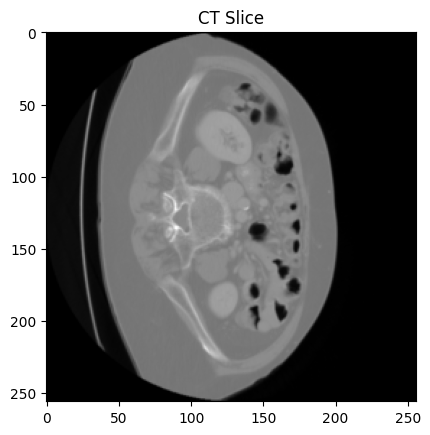

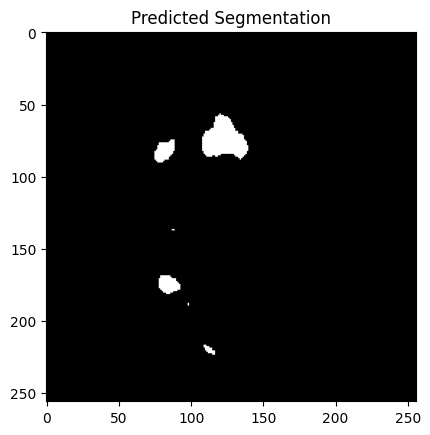

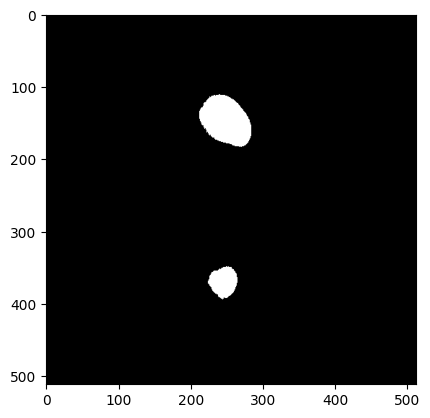

tensor(0.5416, device='cuda:0')
tensor(0.5419)
tensor([0.2127, 0.2974, 0.2954, 0.3469, 0.5093]) tensor([0, 0, 0, 0, 0]) tensor([40, 41, 42, 43, 44])
tensor([0.1970, 0.3707, 0.3983, 0.6042, 0.4718], device='cuda:0')
tensor([0.2127, 0.2974, 0.2954, 0.3469, 0.5093], device='cuda:0')


In [187]:
model.eval()  # Set eval mode once
target_class =4
for epoch in range(num_epochs):
    running_loss = 0.0

    with torch.no_grad():  # Disable grad tracking
        for batch_idx, (X, dsc, case_ids, slice_indices) in enumerate(test_loader):
            print(dsc, case_ids, slice_indices)
            X = X.to(device)
            dsc = dsc.to(device)
            
            outputs = model(X)
            pred_dsc = torch.sigmoid(outputs).squeeze()
            print(pred_dsc)
            print(dsc)

            loss = maeLoss(pred_dsc, dsc)
            running_loss += loss.item()

            # Optional: plot only first batch of first epoch
            if epoch == 0 and batch_idx == 0:
                print(X[4][1].cpu().shape)
                plt.imshow(X[4][0].cpu().numpy(), cmap='gray')
                plt.title("CT Slice")
                plt.show()
                plt.imshow(X[4][1].cpu().numpy(), cmap='gray')
                plt.title("Predicted Segmentation")
                plt.show()
                gt_path = dir / f"labels-{case_ids[4]}.npy"
                gt = (np.load(gt_path)[:, :, slice_indices[4]] == target_class).astype(np.uint8)  # shape: [H, W]
                gt_tensor = torch.tensor(gt).unsqueeze(0).float()  # shape [1, H, W]
                gt_resized = TF.resize(gt_tensor, (256, 256))
                plt.imshow(gt, cmap='gray')
                plt.show()
                print(dsc[4])
                print(1- diceLoss(X[4][1].cpu().unsqueeze(0),gt_resized))
        break
    avg_loss = running_loss / len(test_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Test Loss: {avg_loss:.4f}")

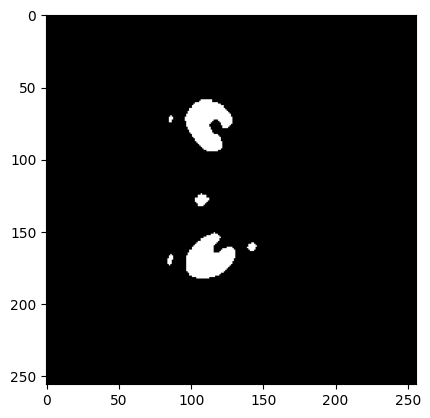

In [122]:
plt.imshow(X[0][1].detach().cpu().numpy(),cmap='gray')

In [15]:
qcData = pd.read_csv("../predictions")
case_number = qcData.case
slice_idx = qcData.slice
dsc = qcData.dsc

FileNotFoundError: [Errno 2] No such file or directory: '../predictions/qcKidneyDsc0.5Continued/results.csv'

In [93]:
qcData = pd.read_csv("predictions/qcKidneyDsc1.0/results.csv")
case_number = qcData.case
slice_idx = qcData.slice
dsc = qcData.dsc
n = 0
segPath = Path(f"predictions/qcKidneyDsc1.0/{case_number[n]}_slice_{slice_idx[n]}_pred.npy")
seg = np.load(segPath)
ctPath = dir / f"volume-{case_number[n]}.npy"
ct = np.load(ctPath)[:,:,slice_idx[n]]

# Resize CT slice
ct = Image.fromarray(ct).convert("F")
ct = TF.resize(ct, (256,256))
ct = np.array(ct, dtype=np.float32)

X = np.stack([ct, seg], axis=0).astype(np.float32)
X = torch.tensor(X).unsqueeze(0)

In [110]:
model = QCUNet()

def init_he(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(init_he)
model = model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.7)

model.train()
num_epochs = 80

X = X.to(device)
dsc_tensor = torch.tensor([dsc[n]], dtype=torch.float32, device=device)

for epoch in range(num_epochs):
    opt.zero_grad()
    outputs = model(X)
    predDSC = torch.sigmoid(outputs)
    loss = maeLoss(predDSC, dsc_tensor)
    loss.backward()
    opt.step()
    scheduler.step()
    print(f"Epoch {epoch}: Loss = {loss.item()}")

# Save model after training
torch.save(model.state_dict(), "qc_unet_overfit.pth")


Epoch 0: Loss = 0.7848139405250549
Epoch 1: Loss = 0.7620207071304321
Epoch 2: Loss = 0.7377638816833496
Epoch 3: Loss = 0.7120381593704224
Epoch 4: Loss = 0.6834508180618286
Epoch 5: Loss = 0.6505779027938843
Epoch 6: Loss = 0.6126081943511963
Epoch 7: Loss = 0.5697599649429321
Epoch 8: Loss = 0.5228103399276733
Epoch 9: Loss = 0.4726947247982025
Epoch 10: Loss = 0.42047998309135437
Epoch 11: Loss = 0.36743050813674927
Epoch 12: Loss = 0.31496506929397583
Epoch 13: Loss = 0.2642830014228821
Epoch 14: Loss = 0.21670913696289062
Epoch 15: Loss = 0.1729605793952942
Epoch 16: Loss = 0.13353604078292847
Epoch 17: Loss = 0.09863024950027466
Epoch 18: Loss = 0.06813013553619385
Epoch 19: Loss = 0.041635096073150635
Epoch 20: Loss = 0.018715381622314453
Epoch 21: Loss = 0.004567980766296387
Epoch 22: Loss = 0.008183836936950684
Epoch 23: Loss = 0.01734262704849243
Epoch 24: Loss = 0.023823559284210205
Epoch 25: Loss = 0.028214573860168457
Epoch 26: Loss = 0.030893981456756592
Epoch 27: Loss =

In [123]:
# Load the same model architecture
model = QCUNet()
model.load_state_dict(torch.load("qc_unet_overfit.pth"))
model = model.to(device)
model.eval()

with torch.no_grad():
    X = X.to(device)
    output = model(X)
    predDSC = torch.sigmoid(output)
    true_dsc_tensor = torch.tensor([dsc[n]], dtype=torch.float32, device=device)
    
    print("Predicted DSC:", predDSC.item())
    print("True DSC:", dsc[n])
    print("MAE:", maeLoss(predDSC, true_dsc_tensor).item())


Predicted DSC: 0.827775239944458
True DSC: 0.84209
MAE: 0.014314770698547363


In [105]:
model = QCUNet()

# He initialization function
def init_he(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(init_he)
model = model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.7)

model.train()
num_epochs = 500

X = X.to(device)
dsc_tensor = torch.tensor([dsc[n]], dtype=torch.float32, device=device)


for epoch in range(num_epochs):
    opt.zero_grad()

    outputs = model(X)                      
    predDSC = torch.sigmoid(outputs)
    loss = maeLoss(predDSC, dsc_tensor)
    loss.backward()
    opt.step()
    scheduler.step()

    print(loss)


tensor(0.0043, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0294, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0262, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0147, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0037, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0063, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0063, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0065, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0084, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0064, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0060, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0085, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0071, device='cuda:0',

KeyboardInterrupt: 

In [98]:
dsc[n]

0.84209

In [103]:
dsc_tensor

tensor([0.8421], device='cuda:0')

In [ ]:
results = []
model_name = os.path.splitext(os.path.basename(model_path))[0]
save_dir = Path("predictions") / model_name
save_dir.mkdir(parents=True, exist_ok=True)
results_csv = save_dir / "results.csv"
with torch.no_grad():
    for batch_idx, (X, case_ids, slice_indices) in enumerate(allLoader):
        inputs = X[:, 0:1, :, :].to(device)
        labels = X[:, 1:, :, :].to(device)

        outputs = torch.sigmoid(model(inputs))
        preds_bin = (outputs > 0.5).float().cpu()

        for i in range(inputs.shape[0]):
            pred_mask = preds_bin[i, 0].numpy()
            dsc_pred = 1 - diceLoss(preds_bin[i:i+1].to(device), labels[i:i+1]).item()
            plt.imshow(labels[i:i+1].cpu().squeeze().squeeze())
            case_id = case_ids[i].item()
            slice_idx = int(slice_indices[i])
            pred_filename = f"{case_id}_slice_{slice_idx}_pred.npy"
            pred_path = save_dir / pred_filename
            np.save(pred_path, pred_mask)

            results.append({
                "case": case_id,
                "slice": slice_idx,
                "model": model_name,
                "dsc": round(dsc_pred, 5),
                "prediction_file": pred_filename
            })
        if case_ids[0] > 2:
            break

# Save results CSV
with open(results_csv, 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=["case", "slice", "model", "dsc", "prediction_file"])
    writer.writeheader()
    writer.writerows(results)

print(f"Saved predictions to {save_dir}")
print(f"Saved CSV summary to {results_csv}")